### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
import pymc as pm
import arviz as az
from tqdm import tqdm
import hssm
import random
import seaborn as sns
from scipy.stats import pearsonr, t
from matplotlib.lines import Line2D

### Parameters

In [2]:
wald_prior_class = "log_normal_prior_centered"
num_sim_exp = 1000
fixed_ndt = 0.25

### Helper functions

In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
def FormatDataDriftRateModels(df_par):    
    
    df_par_sorted = df_par.sort_values(by='ExperimentRoundNumber')
    n_trials = len(df_par)
    
    par_data = {}

    par_rts = []
    par_responses = []
    diff_x_list = []
    diff_p_list = []
    diff_ev_list = []
    experiment_round_numbers = []

    for i in range(n_trials):
    
        df_par_round = df_par.iloc[i]

        #Retrieve reaction time and choices
        par_rts.append(df_par_round['ResponseTimeGamble'])

        choice = df_par_round['GambleChoice']
    
        if choice == 'Left':
            lot = df_par_round['LotteryLeft']
    
        if choice == 'Right':
            lot = df_par_round['LotteryRight']
    
        if lot == 0:
            par_responses.append(-1)
        if lot == 1:
            par_responses.append(1)

        gamble_num = df_par_round['ExperimentGambleNumber']

        round_num = df_par_round['ExperimentRoundNumber']

        experiment_round_numbers.append(round_num)

        gamble_df = df_gambles[df_gambles['GambleNumber']==gamble_num]

        diff_x = gamble_df["lot_1_val"].iloc[0] - gamble_df["lot_0_val"].iloc[0]
        diff_p = gamble_df["lot_1_prob"].iloc[0] - gamble_df["lot_0_prob"].iloc[0]

        diff_x = diff_x/100
        diff_p = diff_p/100

        ev_0 = (gamble_df["lot_0_val"].iloc[0]/100) * (gamble_df["lot_0_prob"].iloc[0]/100)
        ev_1 = (gamble_df["lot_1_val"].iloc[0]/100) * (gamble_df["lot_1_prob"].iloc[0]/100)

        diff_ev = ev_1 - ev_0

        diff_x_list.append(diff_x)
        diff_p_list.append(diff_p)
        diff_ev_list.append(diff_ev)
    
    par_data["diff_x"] = diff_x_list 
    par_data["diff_p"] = diff_p_list 
    par_data["diff_ev"] = diff_ev_list  
    par_data["response"] = par_responses
    par_data["rt"] = par_rts
    par_data["ExperimentRoundNumber"] = experiment_round_numbers

    df_par_data = pd.DataFrame(par_data)

    return df_par_data

In [5]:
def plot_deadline(ax, categories, values, stds, sim_values, deadline, par_group):

    if par_group == 0:
        par_group_label = "All participants"
        colors = ["C0", "C1"]
    elif par_group == 1:
        par_group_label = r"High CT bias, $\beta^{\prime}_{1}\approx \beta^{\prime}_{2}$ participants"
        colors = ["C2", "C3"]
    elif par_group == 2:
        par_group_label = r"Low CT bias, $\beta^{\prime}_{1}<\beta^{\prime}_{2}$ participants"
        colors = ["C4", "C5"]

    ax.errorbar(categories, values, yerr=stds, fmt='o-', color=colors[0], capsize=5, label="Observed ("+par_group_label+")")

    # Plot simulated means
    ax.plot(categories, sim_values, marker='o', linestyle='-', color = colors[1], label="Simulated ("+par_group_label+")")

    # Add deadline line
    ax.plot([categories[0], categories[-1]], [deadline, deadline],
            color='grey', linestyle='--', linewidth=2, label="Target time", zorder=0)

    # Titles, labels, etc.
    ax.set_title(f"{deadline}-second target time", fontsize=16)
    ax.set_xlabel("RT Quantile Category", fontsize=fontsize)

    ax.tick_params(axis='both', which='major', labelsize=fontsize, colors="grey")

    offset = 0.15  # adjust this (e.g., 0.1–0.3) to move labels right
    x_positions = np.arange(len(categories)) + offset



    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories, rotation=45, ha='right')

    # Remove top and right box edges (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for spine in ax.spines.values():
        spine.set_color("grey")

    ax.grid(False)



In [6]:
def standard_error(data):
    """
    Calculate the standard error of the mean (SEM) for a list or NumPy array.

    Parameters
    ----------
    data : list or np.ndarray
        The numeric data values.

    Returns
    -------
    float
        The standard error of the mean.
    """
    data = np.array(data)
    n = len(data)
    if n < 2:
        raise ValueError("Need at least two data points to compute SEM.")
    return np.std(data, ddof=1) / np.sqrt(n)


### Import data and gambles

In [7]:
# Experiment version
exp_version = 2

#Nextcloud credentials
username = 'algarrid'
password = 'faunistico'

In [8]:
# URL of the CSV file 
file_url = 'https://cloud.ilabt.imec.be/remote.php/dav/files/af741990-37f9-103d-9441-9bec5c4808a7/ExperimentsData/risky_dm_2/Gambles/gambles_risky_dm_2.csv'

# Make a request to get the file content
response = requests.get(file_url, auth=(username, password))

# Check if the request was successful
if response.status_code == 200:
    # Stream the content directly into a pandas DataFrame
    csv_content = StringIO(response.text)
    df_gambles = pd.read_csv(csv_content)

    # Now `df` is your DataFrame containing the CSV data
    print("Gambles downloaded")  # Example: print the first few rows
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

Gambles downloaded


In [9]:
try:
    df_processed_experiment_data = pd.read_csv(
        "../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
    )
    #df_processed_experiment_data = pd.read_csv(
    #    "../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
    #)
    print("Successfully loaded processed experiment data")
except FileNotFoundError:
    print("File not found. Please run the preprocessing pipeline first to generate 'processed_reproduction_task_data.csv'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded processed experiment data


In [10]:
df_processed_experiment_data.columns

Index(['ParticipantID', 'BlockNumber', 'ExperimentRoundNumber',
       'ExperimentGambleNumber', 'LotteryLeft', 'LotteryRight', 'GambleChoice',
       'ResponseTimeGamble', 'GambleSecondaryChoices',
       'GambleSecondaryChoicesTimes', 'GamblePresetDeadline',
       'GambleFinalDeadline', 'FullScreenExited', 'ReproducedTime',
       'MissedMaxDeadline', 'SubjectiveDifficulty',
       'ResponseTimeSubjectiveDifficulty',
       'ResponseTimeSubmitAnswersQuestionnaire', 'Log_rt', 'Log_ReproTime'],
      dtype='object')

## Download posterior

In [11]:
idata_wald = az.from_netcdf(f"../model_fitting/idata_wald_{wald_prior_class}.nc")

post = idata_wald.posterior


## Download individual-level fitted parameters

In [12]:
df_wald_fitted_params = pd.read_csv(f'../model_fitting/fitted_parameters/wald/indi_fitted_params_wald_{wald_prior_class}.csv')

par_ids = np.unique(df_wald_fitted_params['Participant_ID'])

n_par = len(par_ids)

df_ddm_fitted_params = pd.read_csv('../model_fitting/fitted_parameters/ddm/fitted_parameters_ddm.csv')

## Predicted Quantile Check

In [14]:
repro_t_quantile_array = np.zeros((n_par,40))

column_names = [
    "Empirical_repro_t_q10",
    "Empirical_repro_t_q30",
    "Empirical_repro_t_q50",
    "Empirical_repro_t_q70",
    "Empirical_repro_t_q90",
    "Simulated_repro_t_q10",
    "Simulated_repro_t_q30",
    "Simulated_repro_t_q50",
    "Simulated_repro_t_q70",
    "Simulated_repro_t_q90",
    "Simulated_mean_repro_t_rt_q20_deadline_6",
    "Simulated_mean_repro_t_rt_q40_deadline_6",
    "Simulated_mean_repro_t_rt_q60_deadline_6",
    "Simulated_mean_repro_t_rt_q80_deadline_6",
    "Simulated_mean_repro_t_rt_q100_deadline_6",
    "Simulated_mean_repro_t_rt_q20_deadline_8",
    "Simulated_mean_repro_t_rt_q40_deadline_8",
    "Simulated_mean_repro_t_rt_q60_deadline_8",
    "Simulated_mean_repro_t_rt_q80_deadline_8",
    "Simulated_mean_repro_t_rt_q100_deadline_8",
    "Simulated_mean_repro_t_rt_q20_deadline_10",
    "Simulated_mean_repro_t_rt_q40_deadline_10",
    "Simulated_mean_repro_t_rt_q60_deadline_10",
    "Simulated_mean_repro_t_rt_q80_deadline_10",
    "Simulated_mean_repro_t_rt_q100_deadline_10",
    "Pred_reg_mean_repro_t_rt_q20_deadline_6",
    "Pred_reg_mean_repro_t_rt_q40_deadline_6",
    "Pred_reg_mean_repro_t_rt_q60_deadline_6",
    "Pred_reg_mean_repro_t_rt_q80_deadline_6",
    "Pred_reg_mean_repro_t_rt_q100_deadline_6",
    "Pred_reg_mean_repro_t_rt_q20_deadline_8",
    "Pred_reg_mean_repro_t_rt_q40_deadline_8",
    "Pred_reg_mean_repro_t_rt_q60_deadline_8",
    "Pred_reg_mean_repro_t_rt_q80_deadline_8",
    "Pred_reg_mean_repro_t_rt_q100_deadline_8",
    "Pred_reg_mean_repro_t_rt_q20_deadline_10",
    "Pred_reg_mean_repro_t_rt_q40_deadline_10",
    "Pred_reg_mean_repro_t_rt_q60_deadline_10",
    "Pred_reg_mean_repro_t_rt_q80_deadline_10",
    "Pred_reg_mean_repro_t_rt_q100_deadline_10",
]

df_repro_t_quantile = pd.DataFrame(repro_t_quantile_array, columns = column_names)


for p, par in tqdm(enumerate(par_ids)):
    
    df_par = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par)]
    
    df_formatted_gamble = FormatDataDriftRateModels(df_par)
    
    df_repro_t_quantile.loc[p,"Empirical_repro_t_q10"] = df_par["ReproducedTime"].quantile(0.1)
    df_repro_t_quantile.loc[p,"Empirical_repro_t_q30"] = df_par["ReproducedTime"].quantile(0.3)
    df_repro_t_quantile.loc[p,"Empirical_repro_t_q50"] = df_par["ReproducedTime"].quantile(0.5)
    df_repro_t_quantile.loc[p,"Empirical_repro_t_q70"] = df_par["ReproducedTime"].quantile(0.7)
    df_repro_t_quantile.loc[p,"Empirical_repro_t_q90"] = df_par["ReproducedTime"].quantile(0.9)  

    rounds_list = np.unique(df_par['ExperimentRoundNumber'])

    n_rounds = len(rounds_list)

    # Get Wald fitted parameters
    df_par_wald_fitted_params = df_wald_fitted_params[df_wald_fitted_params['Participant_ID']==par]

    fitted_wald_beta_0 = df_par_wald_fitted_params['indi_beta0_mean'].iloc[0]
    fitted_wald_beta_1 = df_par_wald_fitted_params['indi_beta1_mean'].iloc[0]
    fitted_wald_beta_2 = df_par_wald_fitted_params['indi_beta2_mean'].iloc[0]
    fitted_wald_drift = df_par_wald_fitted_params['indi_drift_mean'].iloc[0]
    fitted_wald_t = fixed_ndt #df_par_wald_fitted_params['t_nd_mean'].iloc[0] 

    # Get DDM fitted parameters
    df_par_ddm_fitted_params = df_ddm_fitted_params[df_ddm_fitted_params['ParticipantID']==par]

    fitted_ddm_a = df_par_ddm_fitted_params['fitted_a_mean'].iloc[0]
    fitted_ddm_t = df_par_ddm_fitted_params['fitted_t_mean'].iloc[0]
    fitted_ddm_v_diff_p = df_par_ddm_fitted_params['fitted_d_p_mean'].iloc[0]
    fitted_ddm_v_diff_x = df_par_ddm_fitted_params['fitted_d_x_mean'].iloc[0]
    fitted_ddm_v_diff_ev = df_par_ddm_fitted_params['fitted_d_ev_mean'].iloc[0]
        
    #---------------Perform simulations--------------#
    sim_repro_times = np.zeros(n_rounds)
    prior_durs = [0]

    for n, r in enumerate(rounds_list):
        
        df_round = df_par[df_par['ExperimentRoundNumber'] == r]

        # Compute the drift rate of this round for this participant
        df_round_gamble_formatted = df_formatted_gamble[df_formatted_gamble['ExperimentRoundNumber']==r]

        diff_p = df_round_gamble_formatted['diff_p'].iloc[0]
        diff_x = df_round_gamble_formatted['diff_x'].iloc[0]
        diff_ev = df_round_gamble_formatted['diff_ev'].iloc[0]
        
        round_v = fitted_ddm_v_diff_p*diff_p + fitted_ddm_v_diff_x*diff_x + fitted_ddm_v_diff_ev*diff_ev 


        #Simulate ddm
        ddm_sim = hssm.simulate_data(
            model="ddm",
            theta=dict(
                v = round_v,
                a = fitted_ddm_a,
                z = 0.5,
                t = fitted_ddm_t ,
            ),
            size=1,
            random_state = random.randint(0, 999999)
        )
        
        sim_rt = ddm_sim['rt'].iloc[0]

        # Figure out the original deadline
        original_deadline = df_round['GamblePresetDeadline'].iloc[0]

        if sim_rt < original_deadline:
            deadline = original_deadline
        else:
            if sim_rt < 8:
                deadline = 8
            else:
                if sim_rt < 10:
                    deadline = 10
                else:
                    deadline = sim_rt
    
        waiting_time = deadline - sim_rt

    
        # Calculate distribution parameters
        alpha_threshold = fitted_wald_beta_0 + fitted_wald_beta_1*sim_rt + fitted_wald_beta_2*waiting_time
    
        mu = alpha_threshold/fitted_wald_drift
        
        lam = alpha_threshold**2
    
        # Simulate reproduced time using PyMC's Wald distribution
        sim_repro_times[n] = pm.draw(pm.Wald.dist(mu=mu, lam=lam, alpha = fitted_wald_t), draws=1)

        #Learning
        prior_durs.append(deadline)
 
    df_repro_t_quantile.loc[p,"Simulated_repro_t_q10"] = np.percentile(sim_repro_times, 10)
    df_repro_t_quantile.loc[p,"Simulated_repro_t_q30"] = np.percentile(sim_repro_times, 30)
    df_repro_t_quantile.loc[p,"Simulated_repro_t_q50"] = np.percentile(sim_repro_times, 50)
    df_repro_t_quantile.loc[p,"Simulated_repro_t_q70"] = np.percentile(sim_repro_times, 70)
    df_repro_t_quantile.loc[p,"Simulated_repro_t_q90"] = np.percentile(sim_repro_times, 90)


21it [01:08,  3.25s/it]


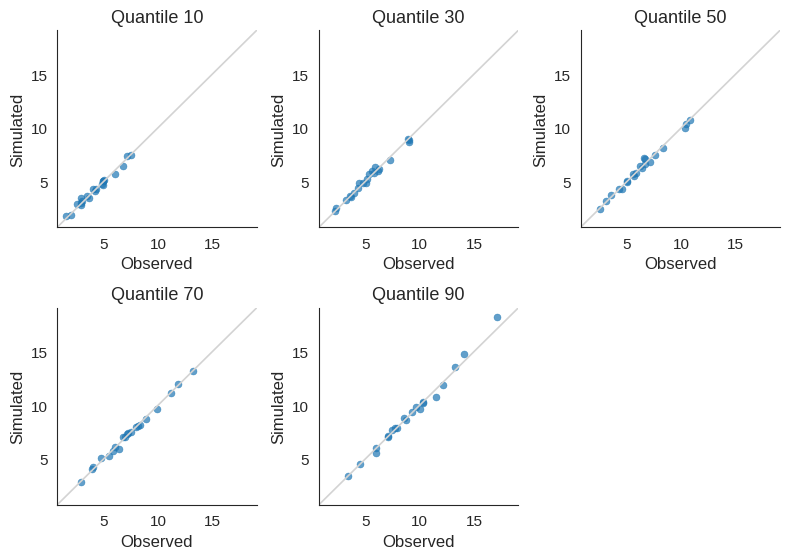

In [58]:

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

# --- Quantiles to plot ---
quantiles = [10, 30, 50, 70, 90]

# --- Create 2x3 grid ---
fig, axes = plt.subplots(2, 3, figsize=(8, 5.7))
axes = axes.flatten()

# --- Find global min/max for consistent axis scaling ---
empirical_cols = [f"Empirical_repro_t_q{q}" for q in quantiles]
simulated_cols = [f"Simulated_repro_t_q{q}" for q in quantiles]

x_min = min(df_repro_t_quantile[empirical_cols].min().min(), df_repro_t_quantile[simulated_cols].min().min())
x_max = max(df_repro_t_quantile[empirical_cols].max().max(), df_repro_t_quantile[simulated_cols].max().max())

# Add a bit of padding
pad = (x_max - x_min) * 0.05
x_min -= pad
x_max += pad

# --- Plot each quantile ---
for i, q in enumerate(quantiles):
    ax = axes[i]
    emp = df_repro_t_quantile[f"Empirical_repro_t_q{q}"]
    sim = df_repro_t_quantile[f"Simulated_repro_t_q{q}"]

    # Scatter plot
    sns.scatterplot(x=emp, y=sim, ax=ax, color="C0", alpha=0.7, s=25, edgecolor=None)

    # Diagonal light grey line
    ax.plot([x_min, x_max], [x_min, x_max], color="lightgrey", linewidth=1.2)

    # Labels and title
    ax.set_title(f"Quantile {q}")
    ax.set_xlabel("Observed")
    ax.set_ylabel("Simulated")

    # Shared axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(x_min, x_max)

    # Clean look — remove top/right spines
    sns.despine(ax=ax, top=True, right=True)

# --- Remove empty subplot (bottom-right) ---
fig.delaxes(axes[-1])

# --- Layout adjustments ---
plt.tight_layout()

# --- Save the figure ---
plt.savefig("../figures/observed_vs_simulated_quantiles_repro_t.svg",
            format="svg", dpi=300, bbox_inches="tight", transparent=True)

plt.show()


## Classify participants

In [13]:
# 1) Posterior for the difference (beta1 - beta2) for each subject
diff = post["indi_beta1"] - post["indi_beta2"]   # dims: chain, draw, subject

# 2) Probability that (beta1 - beta2) < 0 for each subject
prob_below_zero = (diff < 0).mean(dim=("chain", "draw"))

prob_above_zero = (diff > 0).mean(dim=("chain", "draw"))
# prob_below_zero is a DataArray with dim "subject"


mask_negative = prob_below_zero > 0.99

mask_positive = prob_above_zero > 0.99

# Subjects that satisfy the criterion
par_ids_negative_delta_par = prob_below_zero["subject"].values[mask_negative.values]

par_ids_positive_delta_par = prob_above_zero["subject"].values[mask_positive.values]

par_ids_low_delta_par = []

for par in par_ids:
    if par not in par_ids_negative_delta_par and par not in par_ids_positive_delta_par:
        par_ids_low_delta_par.append(par)

## Simulation analysis

In [14]:
par_group = 2

if par_group == 0:
    par_id_list = par_ids
    sim_CVs_deadline_6 = []
    sim_CVs_deadline_8 = []
    sim_CVs_deadline_10 = []
    
elif par_group == 1:
    par_id_list = par_ids_low_delta_par
elif par_group == 2:
    par_id_list = par_ids_negative_delta_par

df_repro_t_quantile = pd.DataFrame()

for p, par in tqdm(enumerate(par_id_list)):

    
    sim_repro_times_deadline_6 = []
    sim_repro_times_deadline_8 = []
    sim_repro_times_deadline_10 = []
    
    df_par = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par)]
    
    df_formatted_gamble = FormatDataDriftRateModels(df_par)


    rounds_list = np.unique(df_par['ExperimentRoundNumber'])

    n_rounds = len(rounds_list)

    # Get Wald fitted parameters
    df_par_wald_fitted_params = df_wald_fitted_params[df_wald_fitted_params['Participant_ID']==par]

    fitted_wald_beta_0 = df_par_wald_fitted_params['indi_beta0_mean'].iloc[0]
    fitted_wald_beta_1 = df_par_wald_fitted_params['indi_beta1_mean'].iloc[0]
    fitted_wald_beta_2 = df_par_wald_fitted_params['indi_beta2_mean'].iloc[0]
    fitted_wald_drift = df_par_wald_fitted_params['indi_drift_mean'].iloc[0]
    fitted_wald_t = fixed_ndt 

    # Get DDM fitted parameters
    df_par_ddm_fitted_params = df_ddm_fitted_params[df_ddm_fitted_params['ParticipantID']==par]

    fitted_ddm_a = df_par_ddm_fitted_params['fitted_a_mean'].iloc[0]
    fitted_ddm_t = df_par_ddm_fitted_params['fitted_t_mean'].iloc[0]
    fitted_ddm_v_diff_p = df_par_ddm_fitted_params['fitted_d_p_mean'].iloc[0]
    fitted_ddm_v_diff_x = df_par_ddm_fitted_params['fitted_d_x_mean'].iloc[0]
    fitted_ddm_v_diff_ev = df_par_ddm_fitted_params['fitted_d_ev_mean'].iloc[0]

    #--------Calculate RT quantiles of the participant-----------#
    # Deadline 6
    df_par_deadline_6 = df_par[
        (df_par["GambleFinalDeadline"] == 6) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
    
    rt_quant_20_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.8)

    # Deadline 8
    df_par_deadline_8 = df_par[
        (df_par["GambleFinalDeadline"] == 8) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
    
    rt_quant_20_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.8)

    # Deadline 10
    df_par_deadline_10 = df_par[
        (df_par["GambleFinalDeadline"] == 10) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
    
    rt_quant_20_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.8)

    sim_repro_t_rt_q20_deadline_6 = []
    sim_repro_t_rt_q40_deadline_6 = []
    sim_repro_t_rt_q60_deadline_6 = []
    sim_repro_t_rt_q80_deadline_6 = []
    sim_repro_t_rt_q100_deadline_6 = []
    
    sim_repro_t_rt_q20_deadline_8 = []
    sim_repro_t_rt_q40_deadline_8 = []
    sim_repro_t_rt_q60_deadline_8 = []
    sim_repro_t_rt_q80_deadline_8 = []
    sim_repro_t_rt_q100_deadline_8 = []
    
    sim_repro_t_rt_q20_deadline_10 = []
    sim_repro_t_rt_q40_deadline_10 = []
    sim_repro_t_rt_q60_deadline_10 = []
    sim_repro_t_rt_q80_deadline_10 = []
    sim_repro_t_rt_q100_deadline_10 = []

    pre_generated_seeds = [random.randint(0, 999999) for _ in range(len(rounds_list))]

    #---------------Perform simulations--------------#
    for n, r in enumerate(rounds_list):

        df_round = df_par[df_par['ExperimentRoundNumber'] == r]

        # Compute the drift rate of this round for this participant
        df_round_gamble_formatted = df_formatted_gamble[df_formatted_gamble['ExperimentRoundNumber']==r]

        diff_p = df_round_gamble_formatted['diff_p'].iloc[0]
        diff_x = df_round_gamble_formatted['diff_x'].iloc[0]
        diff_ev = df_round_gamble_formatted['diff_ev'].iloc[0]
        
        round_v = fitted_ddm_v_diff_p*diff_p + fitted_ddm_v_diff_x*diff_x + fitted_ddm_v_diff_ev*diff_ev 
        
        #Simulate ddm
        ddm_sim = hssm.simulate_data(
            model="ddm",
            theta=dict(
                v = round_v,
                a = fitted_ddm_a,
                z = 0.5,
                t = fitted_ddm_t ,
            ),
            size = num_sim_exp,
            random_state = pre_generated_seeds[n]
        )
        
        sim_rts = ddm_sim['rt'].values

        # Simulate the deadline
        original_deadline = df_round['GamblePresetDeadline'].iloc[0]

        sim_deadlines = np.zeros(num_sim_exp)

        for d in range(num_sim_exp):
            if sim_rts[d] < original_deadline:
                sim_deadlines[d] = original_deadline
            else:
                if sim_rts[d] < 8:
                    sim_deadlines[d] = 8
                else:
                    if sim_rts[d] < 10:
                        sim_deadlines[d] = 10
                    else:
                        sim_deadlines[d] = sim_rts[d]
    
        sim_waiting_times = sim_deadlines - sim_rts
    
        # Calculate distribution parameters

        alpha_threshold = fitted_wald_beta_0 + fitted_wald_beta_1*sim_rts + fitted_wald_beta_2*sim_waiting_times
    
        mu = alpha_threshold/fitted_wald_drift
        
        lam = alpha_threshold**2
    
        # Simulate reproduced time using PyMC's Wald distribution
        sim_repro_times = pm.draw(pm.Wald.dist(mu=mu, lam=lam, alpha = fitted_wald_t))
  
        # Define the quantiles and result containers in dictionaries
        quantiles = {
            6: [rt_quant_20_deadline_6, rt_quant_40_deadline_6, rt_quant_60_deadline_6, rt_quant_80_deadline_6],
            8: [rt_quant_20_deadline_8, rt_quant_40_deadline_8, rt_quant_60_deadline_8, rt_quant_80_deadline_8],
            10: [rt_quant_20_deadline_10, rt_quant_40_deadline_10, rt_quant_60_deadline_10, rt_quant_80_deadline_10]
        }
        
        results = {
            6: [sim_repro_t_rt_q20_deadline_6, sim_repro_t_rt_q40_deadline_6, sim_repro_t_rt_q60_deadline_6, sim_repro_t_rt_q80_deadline_6, sim_repro_t_rt_q100_deadline_6],
            8: [sim_repro_t_rt_q20_deadline_8, sim_repro_t_rt_q40_deadline_8, sim_repro_t_rt_q60_deadline_8, sim_repro_t_rt_q80_deadline_8, sim_repro_t_rt_q100_deadline_8],
            10: [sim_repro_t_rt_q20_deadline_10, sim_repro_t_rt_q40_deadline_10, sim_repro_t_rt_q60_deadline_10, sim_repro_t_rt_q80_deadline_10, sim_repro_t_rt_q100_deadline_10]
        }
        
        # Iterate over the simulations
        for i in range(num_sim_exp):
            deadline = sim_deadlines[i]
            rt = sim_rts[i]
            repro_time = sim_repro_times[i]
        
            if deadline in quantiles:  # Only process defined deadlines
                q = quantiles[deadline]
                r = results[deadline]
        
                if rt <= q[0]:
                    r[0].append(repro_time)
                elif rt <= q[1]:
                    r[1].append(repro_time)
                elif rt <= q[2]:
                    r[2].append(repro_time)
                elif rt <= q[3]:
                    r[3].append(repro_time)
                else:
                    r[4].append(repro_time)

                if par_group == 0:
                    if deadline == 6:
                       sim_repro_times_deadline_6.append(sim_repro_times[i])
                    elif deadline == 8:
                        sim_repro_times_deadline_8.append(sim_repro_times[i])
                    elif deadline == 10:
                        sim_repro_times_deadline_10.append(sim_repro_times[i])

    if par_group == 0:
        sim_CVs_deadline_6.append(np.std(sim_repro_times_deadline_6)/np.mean(sim_repro_times_deadline_6))
        sim_CVs_deadline_8.append(np.std(sim_repro_times_deadline_8)/np.mean(sim_repro_times_deadline_8))
        sim_CVs_deadline_10.append(np.std(sim_repro_times_deadline_10)/np.mean(sim_repro_times_deadline_10))
        


    # Compute averages for all deadlines and quantile bins
    for deadline, result_lists in results.items():
        for q_idx, quantile_bin in enumerate(result_lists):
            quantile_label = f"q{20 * (q_idx + 1)}" if q_idx < 4 else "q100"
            column_name = f"Simulated_mean_repro_t_rt_{quantile_label}_deadline_{deadline}"
            
            # Compute the average of the current quantile bin
            df_repro_t_quantile.loc[p, column_name] = np.average(quantile_bin) if quantile_bin else np.nan
            #df_repro_t_quantile.loc[p, column_name] = np.median(quantile_bin) if quantile_bin else np.nan

repro_times_quant_20_deadline_6 = []
repro_times_quant_40_deadline_6 = []
repro_times_quant_60_deadline_6 = []
repro_times_quant_80_deadline_6 = []
repro_times_quant_100_deadline_6 = []

repro_times_quant_20_deadline_8 = []
repro_times_quant_40_deadline_8 = []
repro_times_quant_60_deadline_8 = []
repro_times_quant_80_deadline_8 = []
repro_times_quant_100_deadline_8 = []


repro_times_quant_20_deadline_10 = []
repro_times_quant_40_deadline_10 = []
repro_times_quant_60_deadline_10 = []
repro_times_quant_80_deadline_10 = []
repro_times_quant_100_deadline_10 = []


for par in par_id_list:
    
    df_par = df_processed_experiment_data[df_processed_experiment_data["ParticipantID"] == par]
    
    # Deadline 6
    df_par_deadline_6 = df_par[
        (df_par["GambleFinalDeadline"] == 6) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
       
    rt_quant_20_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_6 = df_par_deadline_6['ResponseTimeGamble'].quantile(0.8)

    repro_times_quant_0_20 = df_par_deadline_6[df_par_deadline_6['ResponseTimeGamble'] <= rt_quant_20_deadline_6]["ReproducedTime"].values
    repro_times_quant_20_40 = df_par_deadline_6[(rt_quant_20_deadline_6 < df_par_deadline_6['ResponseTimeGamble']) & 
                              (df_par_deadline_6['ResponseTimeGamble'] <= rt_quant_40_deadline_6)]["ReproducedTime"].values
    repro_times_quant_40_60 = df_par_deadline_6[(rt_quant_40_deadline_6 < df_par_deadline_6['ResponseTimeGamble']) & 
                              (df_par_deadline_6['ResponseTimeGamble'] <= rt_quant_60_deadline_6)]["ReproducedTime"].values
    repro_times_quant_60_80 = df_par_deadline_6[(rt_quant_60_deadline_6 < df_par_deadline_6['ResponseTimeGamble']) & 
                              (df_par_deadline_6['ResponseTimeGamble'] <= rt_quant_80_deadline_6)]["ReproducedTime"].values
    repro_times_quant_80_100 = df_par_deadline_6[rt_quant_80_deadline_6 < df_par_deadline_6['ResponseTimeGamble']]["ReproducedTime"].values

    repro_times_quant_20_deadline_6.append(np.average(repro_times_quant_0_20))
    repro_times_quant_40_deadline_6.append(np.average(repro_times_quant_20_40))
    repro_times_quant_60_deadline_6.append(np.average(repro_times_quant_40_60))
    repro_times_quant_80_deadline_6.append(np.average(repro_times_quant_60_80))
    repro_times_quant_100_deadline_6.append(np.average(repro_times_quant_80_100))

    #repro_times_quant_20_deadline_6.append(np.median(repro_times_quant_0_20))
    #repro_times_quant_40_deadline_6.append(np.median(repro_times_quant_20_40))
    #repro_times_quant_60_deadline_6.append(np.median(repro_times_quant_40_60))
    #repro_times_quant_80_deadline_6.append(np.median(repro_times_quant_60_80))
    #repro_times_quant_100_deadline_6.append(np.median(repro_times_quant_80_100))

    # Deadline 8
    df_par_deadline_8 = df_par[
        (df_par["GambleFinalDeadline"] == 8) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
    
    
    rt_quant_20_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_8 = df_par_deadline_8['ResponseTimeGamble'].quantile(0.8)
  
    repro_times_quant_0_20 = df_par_deadline_8[df_par_deadline_8['ResponseTimeGamble'] <= rt_quant_20_deadline_8]["ReproducedTime"].values
    repro_times_quant_20_40 = df_par_deadline_8[(rt_quant_20_deadline_8 < df_par_deadline_8['ResponseTimeGamble']) & 
                              (df_par_deadline_8['ResponseTimeGamble'] <= rt_quant_40_deadline_8)]["ReproducedTime"].values
    repro_times_quant_40_60 = df_par_deadline_8[(rt_quant_40_deadline_8 < df_par_deadline_8['ResponseTimeGamble']) & 
                              (df_par_deadline_8['ResponseTimeGamble'] <= rt_quant_60_deadline_8)]["ReproducedTime"].values
    repro_times_quant_60_80 = df_par_deadline_8[(rt_quant_60_deadline_8 < df_par_deadline_8['ResponseTimeGamble']) & 
                              (df_par_deadline_8['ResponseTimeGamble'] <= rt_quant_80_deadline_8)]["ReproducedTime"].values
    repro_times_quant_80_100 = df_par_deadline_8[rt_quant_80_deadline_8 < df_par_deadline_8['ResponseTimeGamble']]["ReproducedTime"].values

    repro_times_quant_20_deadline_8.append(np.average(repro_times_quant_0_20))
    repro_times_quant_40_deadline_8.append(np.average(repro_times_quant_20_40))
    repro_times_quant_60_deadline_8.append(np.average(repro_times_quant_40_60))
    repro_times_quant_80_deadline_8.append(np.average(repro_times_quant_60_80))
    repro_times_quant_100_deadline_8.append(np.average(repro_times_quant_80_100))


    #repro_times_quant_20_deadline_8.append(np.median(repro_times_quant_0_20))
    #repro_times_quant_40_deadline_8.append(np.median(repro_times_quant_20_40))
    #repro_times_quant_60_deadline_8.append(np.median(repro_times_quant_40_60))
    #repro_times_quant_80_deadline_8.append(np.median(repro_times_quant_60_80))
    #repro_times_quant_100_deadline_8.append(np.median(repro_times_quant_80_100))

    # Deadline 10
    df_par_deadline_10 = df_par[
        (df_par["GambleFinalDeadline"] == 10) & 
        (df_par["MissedMaxDeadline"] == 0)
    ]
    
    rt_quant_20_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.2)
    rt_quant_40_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.4)
    rt_quant_60_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.6)
    rt_quant_80_deadline_10 = df_par_deadline_10['ResponseTimeGamble'].quantile(0.8)

    repro_times_quant_0_20 = df_par_deadline_10[df_par_deadline_10['ResponseTimeGamble'] <= rt_quant_20_deadline_10]["ReproducedTime"].values
    repro_times_quant_20_40 = df_par_deadline_10[(rt_quant_20_deadline_10 < df_par_deadline_10['ResponseTimeGamble']) & 
                              (df_par_deadline_10['ResponseTimeGamble'] <= rt_quant_40_deadline_10)]["ReproducedTime"].values
    repro_times_quant_40_60 = df_par_deadline_10[(rt_quant_40_deadline_10 < df_par_deadline_10['ResponseTimeGamble']) & 
                              (df_par_deadline_10['ResponseTimeGamble'] <= rt_quant_60_deadline_10)]["ReproducedTime"].values
    repro_times_quant_60_80 = df_par_deadline_10[(rt_quant_60_deadline_10 < df_par_deadline_10['ResponseTimeGamble']) & 
                              (df_par_deadline_10['ResponseTimeGamble'] <= rt_quant_80_deadline_10)]["ReproducedTime"].values
    repro_times_quant_80_100 = df_par_deadline_10[rt_quant_80_deadline_10 < df_par_deadline_10['ResponseTimeGamble']]["ReproducedTime"].values

    repro_times_quant_20_deadline_10.append(np.average(repro_times_quant_0_20))
    repro_times_quant_40_deadline_10.append(np.average(repro_times_quant_20_40))
    repro_times_quant_60_deadline_10.append(np.average(repro_times_quant_40_60))
    repro_times_quant_80_deadline_10.append(np.average(repro_times_quant_60_80))
    repro_times_quant_100_deadline_10.append(np.average(repro_times_quant_80_100))

    #repro_times_quant_20_deadline_10.append(np.median(repro_times_quant_0_20))
    #repro_times_quant_40_deadline_10.append(np.median(repro_times_quant_20_40))
    #repro_times_quant_60_deadline_10.append(np.median(repro_times_quant_40_60))
    #repro_times_quant_80_deadline_10.append(np.median(repro_times_quant_60_80))
    #repro_times_quant_100_deadline_10.append(np.median(repro_times_quant_80_100))

values_1 = [np.average(repro_times_quant_20_deadline_6),
          np.average(repro_times_quant_40_deadline_6),
          np.average(repro_times_quant_60_deadline_6),
          np.average(repro_times_quant_80_deadline_6),
          np.average(repro_times_quant_100_deadline_6)]

stds_values_1 = [standard_error(repro_times_quant_20_deadline_6),
                 standard_error(repro_times_quant_40_deadline_6),
                  standard_error(repro_times_quant_60_deadline_6),
                  standard_error(repro_times_quant_80_deadline_6),
                  standard_error(repro_times_quant_100_deadline_6)]

sim_values_1 = [np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q20_deadline_6"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q40_deadline_6"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q60_deadline_6"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q80_deadline_6"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q100_deadline_6"])]


values_2 = [np.average(repro_times_quant_20_deadline_8),
          np.average(repro_times_quant_40_deadline_8),
          np.average(repro_times_quant_60_deadline_8),
          np.average(repro_times_quant_80_deadline_8),
          np.average(repro_times_quant_100_deadline_8)]

stds_values_2 = [standard_error(repro_times_quant_20_deadline_8),
                 standard_error(repro_times_quant_40_deadline_8),
                 standard_error(repro_times_quant_60_deadline_8),
                 standard_error(repro_times_quant_80_deadline_8),
                 standard_error(repro_times_quant_100_deadline_8)]

sim_values_2 = [np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q20_deadline_8"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q40_deadline_8"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q60_deadline_8"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q80_deadline_8"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q100_deadline_8"])]


values_3 = [np.average(repro_times_quant_20_deadline_10),
          np.average(repro_times_quant_40_deadline_10),
          np.average(repro_times_quant_60_deadline_10),
          np.average(repro_times_quant_80_deadline_10),
          np.average(repro_times_quant_100_deadline_10)]

stds_values_3 = [standard_error(repro_times_quant_20_deadline_10),
                 standard_error(repro_times_quant_40_deadline_10),
                  standard_error(repro_times_quant_60_deadline_10),
                  standard_error(repro_times_quant_80_deadline_10),
                  standard_error(repro_times_quant_100_deadline_10)]

sim_values_3 = [np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q20_deadline_10"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q40_deadline_10"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q60_deadline_10"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q80_deadline_10"]),
              np.average(df_repro_t_quantile["Simulated_mean_repro_t_rt_q100_deadline_10"])]




9it [07:12, 48.10s/it]


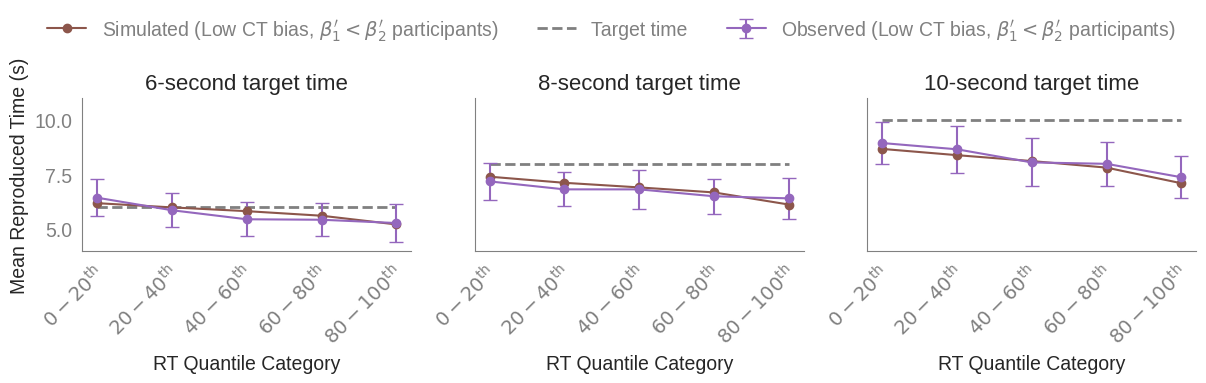

In [15]:
categories = [r"0-20%", r"20-40%", r"40-60%", r"60-80%", r"80-100%"]

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})


fig, axes = plt.subplots(1, 3, figsize=(12, 3.7), sharey=True)  # Share y-axis for comparison

fontsize = 14
# Plot each deadline
# Plot for each deadline
plot_deadline(axes[0], categories, values_1, stds_values_1, sim_values_1, 6, par_group)
plot_deadline(axes[1], categories, values_2, stds_values_2, sim_values_2, 8,par_group)
plot_deadline(axes[2], categories, values_3, stds_values_3, sim_values_3, 10,par_group)

axes[0].set_ylabel("Mean Reproduced Time (s)", fontsize=fontsize)

# Shared legend on the right
# Collect handles and labels from one axis (all are the same)
handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center right', frameon=False, fontsize=fontsize)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(handles), frameon=False, fontsize=fontsize, labelcolor = "grey")

# Adjust layout so legend fits on the right
#plt.tight_layout(rect=[0, 0, 0.7, 1])    # leave space for legend

plt.tight_layout(rect=[0, 0, 1, 0.89]) 
plt.ylim(4, 11)


#plt.savefig(f'../figures/sim_analysis_par_group{par_group}.svg', format='svg',bbox_inches='tight', transparent=True)
plt.show()



## Simulated versus empirical evolution of Coefficient of Variation as a function of target time

In [18]:
par_CVs_deadline_6 = []
par_CVs_deadline_8 = []
par_CVs_deadline_10 = []

IQR_repro_ts =  np.zeros(n_par)
average_repro = np.zeros(n_par)


for p, par in enumerate(par_ids):

    df_par = df_processed_experiment_data[df_processed_experiment_data['ParticipantID']==par]
    
    df_par_deadline_6 = df_par[(df_par['GambleFinalDeadline']==6) & 
                                (df_par['MissedMaxDeadline']==0) #&
                           
                                    
    ]
    
    df_par_deadline_8 = df_par[(df_par['GambleFinalDeadline']==8) & 
                                (df_par['MissedMaxDeadline']==0) #&
                         
    ]
    
    df_par_deadline_10 = df_par[(df_par['GambleFinalDeadline']==10) & 
                                (df_par['MissedMaxDeadline']==0) #&
                                       
    ]
    
    par_CVs_deadline_6.append(np.std(df_par_deadline_6['ReproducedTime'].values)/np.mean(df_par_deadline_6['ReproducedTime'].values))
    par_CVs_deadline_8.append(np.std(df_par_deadline_8['ReproducedTime'].values)/np.mean(df_par_deadline_8['ReproducedTime'].values))
    par_CVs_deadline_10.append(np.std(df_par_deadline_10['ReproducedTime'].values)/np.mean(df_par_deadline_10['ReproducedTime'].values))

    IQR_repro_ts[p] = df_par['ReproducedTime'].quantile(0.75) - df_par['ReproducedTime'].quantile(0.25)
    average_repro[p] =  np.mean(df_par['ReproducedTime'])

    

# Means of CV across participant for deadline 6
mean_CVs = [np.mean(par_CVs_deadline_6), np.mean(par_CVs_deadline_8), np.mean(par_CVs_deadline_10)]

# sems of CV across participant for deadline 6
sem_CVs = [standard_error(par_CVs_deadline_6), 
           standard_error(par_CVs_deadline_8),
           standard_error(par_CVs_deadline_10)
          ]

Mean simulated CV for 6-second target time: 0.29959519928942113
Mean simulated CV for 10-second target time: 0.27304522465163283
Median simulated CV for 6-second target time: 0.2845307911563464
Median simulated CV for 10-second target time: 0.2526740141873589


/tmp/ipykernel_5304/3495316083.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_b.boxplot(


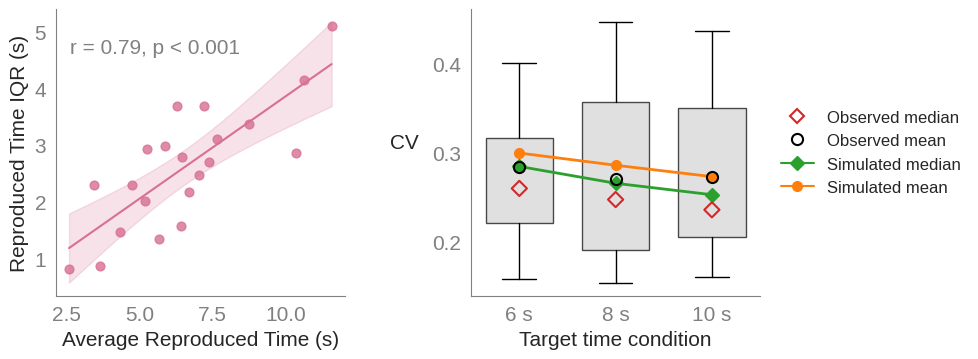

In [20]:
mean_sim_CVs_deadline_6 = np.mean(sim_CVs_deadline_6)
mean_sim_CVs_deadline_8 = np.mean(sim_CVs_deadline_8)
mean_sim_CVs_deadline_10 = np.mean(sim_CVs_deadline_10)

median_sim_CVs_deadline_6 = np.median(sim_CVs_deadline_6)
median_sim_CVs_deadline_8 = np.median(sim_CVs_deadline_8)
median_sim_CVs_deadline_10 = np.median(sim_CVs_deadline_10)

print("Mean simulated CV for 6-second target time: "+str(mean_sim_CVs_deadline_6))
print("Mean simulated CV for 10-second target time: "+str(mean_sim_CVs_deadline_10))

print("Median simulated CV for 6-second target time: "+str(median_sim_CVs_deadline_6))
print("Median simulated CV for 10-second target time: "+str(median_sim_CVs_deadline_10))

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

fontsize = 20

# Optional helper for significance bars (unused here, but kept for completeness)
def add_sig_bar(ax, x1, x2, y, h, text, color="grey"):
    ax.plot(
        [x1, x1, x2, x2],
        [y,  y + h, y + h, y],
        lw=1.5,
        c=color
    )
    ax.text(
        (x1 + x2) / 2,
        y + h,
        text,
        ha='center',
        va='bottom',
        color=color,
        fontsize=fontsize
    )

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(11, 3.7))

# ------------------------------------------------------------------
# LEFT PANEL: correlation + regression line + CI
# ------------------------------------------------------------------
ax = ax_left

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color("grey")
ax.spines['left'].set_color("grey")

ax.tick_params(axis='both', which='major', labelsize=15, colors="grey")

x = np.asarray(average_repro)
y = np.asarray(IQR_repro_ts)

corr_coefficient, p_value = pearsonr(x, y)

# Linear regression fit
slope, intercept = np.polyfit(x, y, 1)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = slope * x_fit + intercept

# CI for regression line
n = x.size
y_hat = slope * x + intercept
residuals = y - y_hat
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)
t_val = t.ppf(1 - 0.025, df=n - 2)

se_fit = s_err * np.sqrt(1/n + (x_fit - x_mean)**2 / Sxx)
ci_upper = y_fit + t_val * se_fit
ci_lower = y_fit - t_val * se_fit

ax.scatter(
    x, y,
    label='Data',
    color="#d87093",
    s=40,
    alpha=0.8
)

ax.plot(x_fit, y_fit, color='#d87093', label='Best fit line')
ax.fill_between(
    x_fit, ci_lower, ci_upper,
    color="#d87093",
    alpha=0.2,
    label='95% CI'
)

ax.set_xlabel("Average Reproduced Time (s)", fontsize=15)
ax.set_ylabel("Reproduced Time IQR (s)", fontsize=15)

for tick_label in ax.get_xticklabels() + ax.get_yticklabels():
    tick_label.set_color("grey")

if p_value < 0.0001:
    text_str = f'r = {corr_coefficient:.2f}, p < 0.001'
else:
    text_str = f'r = {corr_coefficient:.2f}, p = {p_value:.3f}'

ax.text(
    0.05, 0.9, text_str,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment='top',
    color="grey"
)

# ------------------------------------------------------------------
# RIGHT PANEL: boxplots of CV by deadline + objective & simulated stats
# ------------------------------------------------------------------
ax_b = ax_right

ax_b.spines['top'].set_visible(False)
ax_b.spines['right'].set_visible(False)
ax_b.spines['bottom'].set_color("grey")
ax_b.spines['left'].set_color("grey")

ax_b.tick_params(axis='both', which='major', labelsize=15, colors="grey")

data = [par_CVs_deadline_6, par_CVs_deadline_8, par_CVs_deadline_10]
labels = ['6 s', '8 s', '10 s']

bp = ax_b.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    showmeans=True,
    widths=0.7,
    meanprops=dict(
        marker='o',              # diamond for objective mean
        markerfacecolor='none',
        markeredgecolor='black',
        markersize=8,
                 # bigger circle
        markeredgewidth=1.5   
   
    ),
    showfliers=False
)

# Style boxes
for box in bp['boxes']:
    box.set(facecolor='lightgrey', alpha=0.7)

# Hide default median lines (we'll draw our own markers)
for med in bp['medians']:
    med.set_visible(False)

ax_b.set_xlabel('Target time condition', fontsize=15)
ax_b.set_ylabel('CV', fontsize=15, rotation=0, labelpad=20)

for tick_label in ax_b.get_xticklabels() + ax_b.get_yticklabels():
    tick_label.set_color("grey")

# --- Objective medians as hollow diamonds ---
x_pos = np.array([1, 2, 3])
obj_medians = np.array([
    np.median(par_CVs_deadline_6),
    np.median(par_CVs_deadline_8),
    np.median(par_CVs_deadline_10)
])

ax_b.scatter(
    x_pos,
    obj_medians,
    marker='D',
    s=60,
    facecolors='none',
    edgecolors='C3',
    linewidths=1.5,
    zorder=4
)

# --- Simulated means and medians ---
sim_means = np.array([
    mean_sim_CVs_deadline_6,
    mean_sim_CVs_deadline_8,
    mean_sim_CVs_deadline_10
])

sim_medians = np.array([
    median_sim_CVs_deadline_6,
    median_sim_CVs_deadline_8,
    median_sim_CVs_deadline_10
])

line_sim_mean, = ax_b.plot(
    x_pos,
    sim_means,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=7,
    color="C1"
)

line_sim_med, = ax_b.plot(
    x_pos,
    sim_medians,
    marker="D",
    linestyle="-",
    linewidth=2,
    markersize=7,
    color="C2"
)

# ---- Legend using proxy artists ----
legend_handles = [
    # Objective median (hollow diamond)
    Line2D(
        [0], [0],
        marker='D',
        linestyle='None',
        markerfacecolor='none',
        markeredgecolor='C3',
        markersize=7,
        label='Observed median',
        markeredgewidth=1.5
    ),
    # Objective mean (filled diamond)
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        markerfacecolor='none',
        markeredgecolor='black',
        markersize=8,
        markeredgewidth=1.5,
        label='Observed mean'
    ),
    # Simulated median
    Line2D(
        [0], [0],
        marker='D',
        linestyle='-',
        color='C2',
        markersize=7,
        label='Simulated median'
    ),
    # Simulated mean
    Line2D(
        [0], [0],
        marker='o',
        linestyle='-',
        color='C1',
        markersize=7,
        label='Simulated mean'
    ),
]

ax_b.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=12
)

plt.tight_layout(w_pad=2.5, rect=[0, 0, 0.9, 1])
plt.savefig("../figures/cv_plots.svg", format="svg", bbox_inches="tight")
plt.show()


## Effect of difference in expected value on time perception

In [14]:
df_pure = df_processed_experiment_data[
    (df_processed_experiment_data['GamblePresetDeadline'] == df_processed_experiment_data['GambleFinalDeadline']) & 
    (df_processed_experiment_data['MissedMaxDeadline'] == 0)
]

selected_gambles = []

for i in range(160):
    df_gamble = df_pure[df_pure['ExperimentGambleNumber']==i+1]
    paars = np.unique(df_gamble['ParticipantID'])
    if len(paars) == len(par_ids):
        selected_gambles.append(i+1)

n_rounds = 160

gambles_id_and_median_rt = np.zeros((len(selected_gambles),10))

list_of_list = []

for i, gam in enumerate(selected_gambles):
    gambles_id_and_median_rt[i,0] = gam
    df_current_gamble = df_processed_experiment_data[(df_processed_experiment_data['ExperimentGambleNumber'] == gam)]
    rt = df_current_gamble['ResponseTimeGamble']
    djr = df_current_gamble['ReproducedTime']/df_current_gamble['GambleFinalDeadline']
    repro_t = df_current_gamble['ReproducedTime']
    
    gambles_id_and_median_rt[i,1] = np.mean(rt)
    
    current_gamble = df_gambles[df_gambles['GambleNumber'] == gam]
    
    gambles_id_and_median_rt[i,2] = current_gamble['lot_0_val'].iloc[0]
    gambles_id_and_median_rt[i,3] = current_gamble['lot_0_prob'].iloc[0]
    gambles_id_and_median_rt[i,4] = current_gamble['lot_1_val'].iloc[0]
    gambles_id_and_median_rt[i,5] = current_gamble['lot_1_prob'].iloc[0]
    gambles_id_and_median_rt[i,6] = current_gamble['dX'].iloc[0]
    gambles_id_and_median_rt[i,7] = current_gamble['dP'].iloc[0]
    #gambles_id_and_median_rt[i,8] = abs(current_gamble['dEV'].iloc[0])
    gambles_id_and_median_rt[i,8] = current_gamble['dEV'].iloc[0]
    #gambles_id_and_median_rt[i,9] = np.median(repro_t)
    #gambles_id_and_median_rt[i,9] = np.mean(djr)
    #gambles_id_and_median_rt[i,9] = np.median(djr)
    gambles_id_and_median_rt[i,9] = np.mean(djr)
    list_of_list.append(list(djr))
    #gambles_id_and_median_rt[i,9] = np.mean(djr)

sim_mean_djr_dev_minus_40_minus_20 = []
sim_mean_djr_dev_minus_20_0 = []
sim_mean_djr_dev_0_20 = []
sim_mean_djr_dev_20_40 = []
sim_mean_djr_dev_40_60 = []
sim_mean_djr_dev_60_80 = []

In [33]:
df_pure = df_processed_experiment_data[
    (df_processed_experiment_data['GamblePresetDeadline'] == df_processed_experiment_data['GambleFinalDeadline']) & 
    (df_processed_experiment_data['MissedMaxDeadline'] == 0)
]

selected_gambles = []

for i in range(160):
    df_gamble = df_pure[df_pure['ExperimentGambleNumber']==i+1]
    paars = np.unique(df_gamble['ParticipantID'])
    if len(paars) == len(par_ids):
        selected_gambles.append(i+1)

n_rounds = 160

gambles_id_and_median_rt = np.zeros((len(selected_gambles),10))

list_of_list = []

for i, gam in enumerate(selected_gambles):
    gambles_id_and_median_rt[i,0] = gam
    df_current_gamble = df_processed_experiment_data[(df_processed_experiment_data['ExperimentGambleNumber'] == gam)]
    rt = df_current_gamble['ResponseTimeGamble']
    djr = df_current_gamble['ReproducedTime']/df_current_gamble['GambleFinalDeadline']
    repro_t = df_current_gamble['ReproducedTime']
    
    gambles_id_and_median_rt[i,1] = np.mean(rt)
    
    current_gamble = df_gambles[df_gambles['GambleNumber'] == gam]
    
    gambles_id_and_median_rt[i,2] = current_gamble['lot_0_val'].iloc[0]
    gambles_id_and_median_rt[i,3] = current_gamble['lot_0_prob'].iloc[0]
    gambles_id_and_median_rt[i,4] = current_gamble['lot_1_val'].iloc[0]
    gambles_id_and_median_rt[i,5] = current_gamble['lot_1_prob'].iloc[0]
    gambles_id_and_median_rt[i,6] = current_gamble['dX'].iloc[0]
    gambles_id_and_median_rt[i,7] = current_gamble['dP'].iloc[0]
    #gambles_id_and_median_rt[i,8] = abs(current_gamble['dEV'].iloc[0])
    gambles_id_and_median_rt[i,8] = current_gamble['dEV'].iloc[0]
    #gambles_id_and_median_rt[i,9] = np.median(repro_t)
    #gambles_id_and_median_rt[i,9] = np.mean(djr)
    #gambles_id_and_median_rt[i,9] = np.median(djr)
    gambles_id_and_median_rt[i,9] = np.mean(djr)
    list_of_list.append(list(djr))
    #gambles_id_and_median_rt[i,9] = np.mean(djr)

sim_mean_djr_dev_minus_40_minus_20 = []
sim_mean_djr_dev_minus_20_0 = []
sim_mean_djr_dev_0_20 = []
sim_mean_djr_dev_20_40 = []
sim_mean_djr_dev_40_60 = []
sim_mean_djr_dev_60_80 = []

num_sim_exp = 500

for p, par in tqdm(enumerate(par_ids)):
    
    # Get Wald fitted parameters
    df_par_wald_fitted_params = df_wald_fitted_params[df_wald_fitted_params['Participant_ID']==par]

    fitted_wald_beta_0 = df_par_wald_fitted_params['indi_beta0_mean'].iloc[0]
    fitted_wald_beta_1 = df_par_wald_fitted_params['indi_beta1_mean'].iloc[0]
    fitted_wald_beta_2 = df_par_wald_fitted_params['indi_beta2_mean'].iloc[0]
    fitted_wald_drift = df_par_wald_fitted_params['indi_drift_mean'].iloc[0]
    fitted_wald_t = fixed_ndt  #df_par_wald_fitted_params['t_nd_mean'].iloc[0] 

    # Get DDM fitted parameters
    df_par_ddm_fitted_params = df_ddm_fitted_params[df_ddm_fitted_params['ParticipantID']==par]

    fitted_ddm_a = df_par_ddm_fitted_params['fitted_a_mean'].iloc[0]
    fitted_ddm_t = df_par_ddm_fitted_params['fitted_t_mean'].iloc[0]
    fitted_ddm_v_diff_p = df_par_ddm_fitted_params['fitted_d_p_mean'].iloc[0]
    fitted_ddm_v_diff_x = df_par_ddm_fitted_params['fitted_d_x_mean'].iloc[0]
    fitted_ddm_v_diff_ev = df_par_ddm_fitted_params['fitted_d_ev_mean'].iloc[0]


    #---------------Perform simulations--------------#
    for n, gam in enumerate(selected_gambles):

        sim_gamble_djr = []

        current_gamble = df_gambles[df_gambles['GambleNumber'] == gam]


        original_deadline = current_gamble['Deadline'].iloc[0]
    
        lot_0_val = current_gamble['lot_0_val'].iloc[0]/100
        lot_0_prob = current_gamble['lot_0_prob'].iloc[0]/100
        lot_1_val = current_gamble['lot_1_val'].iloc[0]/100
        lot_1_prob = current_gamble['lot_1_prob'].iloc[0]/100

        ev_0 = lot_0_val * lot_0_prob
        ev_1 = lot_1_val * lot_1_prob

        diff_x = lot_1_val - lot_0_val
        diff_p = lot_1_prob - lot_0_prob
        diff_ev = ev_1 - ev_0

        # Compute the drift rate of this gamble for this participant
        round_v = fitted_ddm_v_diff_p*diff_p + fitted_ddm_v_diff_x*diff_x + fitted_ddm_v_diff_ev*diff_ev 
        

        #-------------Perform simulations--------------#
        while len(sim_gamble_djr) != num_sim_exp:

            #Simulate ddm
            ddm_sim = hssm.simulate_data(
                model="ddm",
                theta=dict(
                    v = round_v,
                    a = fitted_ddm_a,
                    z = 0.5,
                    t = fitted_ddm_t ,
                ),
                size = 1,
                random_state = random.randint(0, 999999)
            )
        
            sim_rt = ddm_sim['rt'].iloc[0]

            if sim_rt < original_deadline:
                sim_wt = original_deadline - sim_rt
    
                # Calculate distribution parameters
                alpha_threshold = fitted_wald_beta_0 + fitted_wald_beta_1*sim_rt + fitted_wald_beta_2*sim_wt
    
                mu = alpha_threshold/fitted_wald_drift
        
                lam = alpha_threshold**2
    
                # Simulate reproduced time using PyMC's Wald distribution
                sim_repro_t = pm.draw(pm.Wald.dist(mu=mu, lam=lam, alpha = fitted_wald_t))

                sim_gamble_djr.append(sim_repro_t/original_deadline)
        
        mean_sim_gamble_djr = np.mean(sim_gamble_djr)
  
        if -0.4 < (-diff_ev) <= -0.2:
            sim_mean_djr_dev_minus_40_minus_20.append(mean_sim_gamble_djr)
        if -0.2 < (-diff_ev) <= 0:
            sim_mean_djr_dev_minus_20_0.append(mean_sim_gamble_djr)
        if 0 < (-diff_ev) <= 0.2:
            sim_mean_djr_dev_0_20.append(mean_sim_gamble_djr)
        if 0.2 < (-diff_ev) <= 0.4:
            sim_mean_djr_dev_20_40.append(mean_sim_gamble_djr)
        if 0.4 < (-diff_ev) <= 0.6:
            sim_mean_djr_dev_40_60.append(mean_sim_gamble_djr)
        if 0.6 < (-diff_ev) <= 0.8:
            sim_mean_djr_dev_60_80.append(mean_sim_gamble_djr)
        
  
df = pd.DataFrame(gambles_id_and_median_rt)
df.to_csv("gambles_id_and_median_rt_wald_processed.csv", index=False, header=False)

21it [2:20:20, 401.00s/it]


In [ ]:
df = pd.read_csv('gambles_id_and_median_rt_wald_processed.csv')  # as a DataFrame
gambles_id_and_median_rt = df.values  

In [39]:
x = gambles_id_and_median_rt[:, 8]  # dEV
y = gambles_id_and_median_rt[:, 9]  # Median RT (s)

# Define bin edges (you can adjust these values as needed)
bin_edges = [-40, -20, 0, 20, 40,60,80]  # Replace with your own vertical line positions
bin_centers = (np.array(bin_edges[:-1]) + np.array(bin_edges[1:])) / 2

bin_minus_40_minus_20 = []
bin_minus_20_minus_0 = []
bin_0_20 = []
bin_20_40 = []
bin_40_60 = []
bin_60_80 = []

for i in range(len(x)):
    if -40 < x[i] <= -20:
        bin_minus_40_minus_20.append(y[i])
    if -20 < x[i] <= 0:
        bin_minus_20_minus_0.append(y[i])
    if 0 < x[i] <= 20:
        bin_0_20.append(y[i])
    if 20 < x[i] <= 40:
        bin_20_40.append(y[i])
    if 40 < x[i] <= 60:
        bin_40_60.append(y[i])
    if 60 < x[i] <= 80:
        bin_60_80.append(y[i])
        



sim_means = [np.mean(sim_mean_djr_dev_minus_40_minus_20),
                np.mean(sim_mean_djr_dev_minus_20_0),
                np.mean(sim_mean_djr_dev_0_20),
                np.mean(sim_mean_djr_dev_20_40),
                np.mean(sim_mean_djr_dev_40_60),
                np.mean(sim_mean_djr_dev_60_80)]

binned_means = [np.mean(bin_minus_40_minus_20),
                np.mean(bin_minus_20_minus_0),
                np.mean(bin_0_20),
                np.mean(bin_20_40),
                np.mean(bin_40_60),
                np.mean(bin_60_80)]

binned_stds = [standard_error(bin_minus_40_minus_20),
                standard_error(bin_minus_20_minus_0),
                standard_error(bin_0_20),
                standard_error(bin_20_40),
                standard_error(bin_40_60),
                standard_error(bin_60_80)]

In [40]:
print(len(x))

69


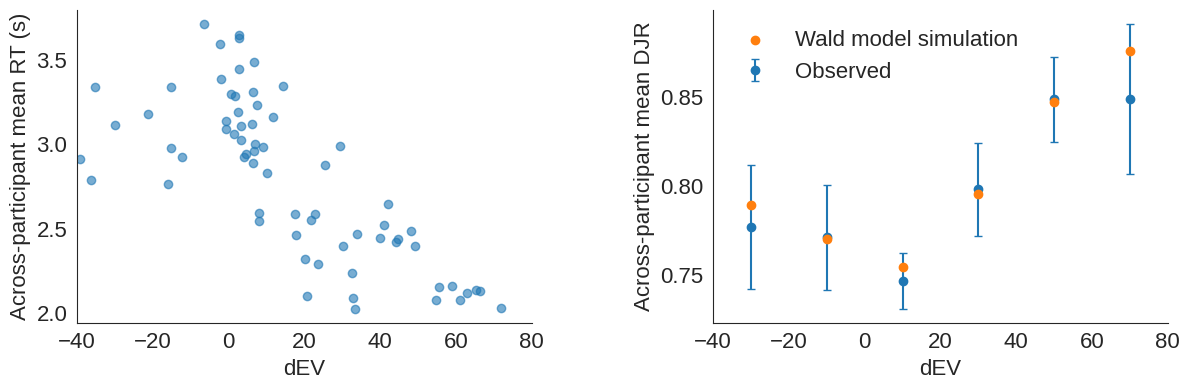

In [58]:

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fontsize = 16

# -----------------------
# Left plot: dEV vs Mean RT
# -----------------------
axes[0].scatter(gambles_id_and_median_rt[:, 8], gambles_id_and_median_rt[:, 1], color='C0', alpha=0.6)
axes[0].set_xlabel("dEV", fontsize=fontsize)
axes[0].set_ylabel("Across-participant mean RT (s)", fontsize=fontsize)
axes[0].set_xlim(-40, 80)

# -----------------------
# Right plot: dEV vs Mean DJR
# -----------------------
axes[1].set_xlabel("dEV", fontsize=fontsize)
axes[1].set_ylabel("Across-participant mean DJR", fontsize=fontsize)

# empirical with error bars
axes[1].errorbar(
    bin_centers,
    binned_means,
    yerr=binned_stds,
    fmt='o',
    capsize=3,
    label='Observed',
    zorder=1, alpha=1)


# model points
axes[1].scatter(bin_centers, sim_means, color='C1', label='Wald model simulation',  zorder=2, alpha=1)
axes[1].set_xlim(-40, 80)

# -----------------------
# Style both axes
# -----------------------
for ax in axes:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

axes[1].legend(fontsize=fontsize, frameon=False)

plt.tight_layout(w_pad=6.0)
plt.subplots_adjust(wspace=0.4)  # extra space between plots

# --- Optional save ---
plt.savefig('../figures/dev_mean_rt_mean_djr_combined.svg', format='svg',bbox_inches='tight', transparent=True)
plt.show()


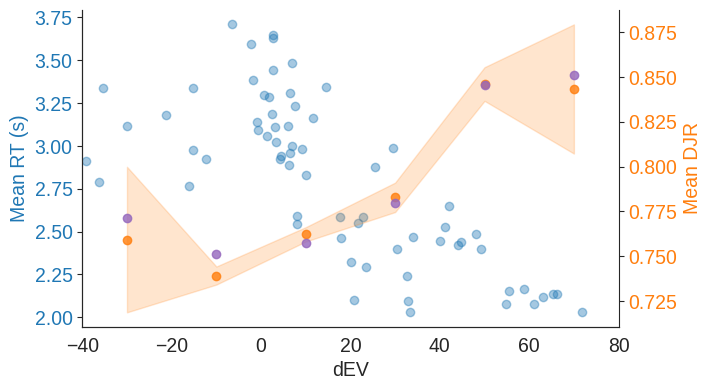

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})

fontsize = 14

# Create one figure and one main axis
fig, ax1 = plt.subplots(figsize=(7, 4))

# --- Left y-axis: Mean RT ---
ax1.scatter(
    gambles_id_and_median_rt[:, 8],  # dEV
    gambles_id_and_median_rt[:, 1],  # Mean RT
    color="C0",
    alpha=0.4,
    label="Mean RT (s)"
)
ax1.set_xlabel("dEV", fontsize=fontsize)
ax1.set_ylabel("Mean RT (s)", color="C0", fontsize=fontsize)
ax1.tick_params(axis="y", labelcolor="C0", labelsize=fontsize)
ax1.tick_params(axis="x", labelsize=fontsize)
ax1.set_xlim(-40, 80)
#ax1.grid(True, alpha=0.3)

# --- Right y-axis: Mean DJR ---
ax2 = ax1.twinx()

# Plot the average points for each bin (Empirical)
ax2.scatter(bin_centers, binned_means, color="C1", label="Empirical", alpha=0.8)
ax2.fill_between(
    bin_centers,
    [v - s for v, s in zip(binned_means, binned_stds)],
    [v + s for v, s in zip(binned_means, binned_stds)],
    color="C1",
    alpha=0.2
)
# Plot simulated means (DDM-Wald)
ax2.scatter(bin_centers, sim_means, color="C4", label="DDM-Wald model", alpha=0.8)

ax2.set_ylabel("Mean DJR", color="C1", fontsize=fontsize)
ax2.tick_params(axis="y", labelcolor="C1", labelsize=fontsize)
ax2.set_xlim(-40, 80)

# --- Combined legend (from both axes) ---
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", fontsize=fontsize, frameon=False)

# --- Clean look ---
sns.despine(ax=ax1, top=True, right=False)
sns.despine(ax=ax2, left=False, top=True)
plt.tight_layout()

# --- Optional save ---
# plt.savefig('../figures/dev_mean_rt_mean_djr_combined.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)

plt.show()



In [124]:
df_pure = df_processed_experiment_data[
    (df_processed_experiment_data['GamblePresetDeadline'] == df_processed_experiment_data['GambleFinalDeadline']) & 
    (df_processed_experiment_data['MissedMaxDeadline'] == 0) #& 
    #(df_processed_experiment_data['GamblePresetDeadline'] == 10)
]

selected_gambles = []

for i in range(160):
    df_gamble = df_pure[df_pure['ExperimentGambleNumber']==i+1]
    paars = np.unique(df_gamble['ParticipantID'])
    if len(paars) == len(par_ids):
        selected_gambles.append(i+1)




all_gambles_list = selected_gambles 
#all_gambles_list =np.unique(df_processed_experiment_data['ExperimentGambleNumber'])
dEVs = np.zeros(len(all_gambles_list))



mean_DJRs = np.zeros(len(all_gambles_list))
mean_RTs = np.zeros(len(all_gambles_list))
mean_ReproTs = np.zeros(len(all_gambles_list))

deadline_list = np.zeros(len(all_gambles_list))


list_of_list = []

for i, gam in enumerate(all_gambles_list):
    df_current_gamble = df_processed_experiment_data[(df_processed_experiment_data['ExperimentGambleNumber'] == gam)]
    rt = df_current_gamble['ResponseTimeGamble'].values
    djr = df_current_gamble['ReproducedTime']/df_current_gamble['GambleFinalDeadline']
    repro_t = df_current_gamble['ReproducedTime'].values
    
    mean_RTs[i] = np.mean(rt)

    mean_ReproTs[i] = np.mean(repro_t)
    
    current_gamble = df_gambles[df_gambles['GambleNumber'] == gam]
    
    dEVs[i] = current_gamble['dEV'].iloc[0]

    mean_DJRs[i] = np.mean(djr)
    list_of_list.append(list(djr))
    deadline_list[i]=df_current_gamble['GambleFinalDeadline'].iloc[0]
 

sim_mean_djr_dev_minus_40_minus_20 = []
sim_mean_djr_dev_minus_20_0 = []
sim_mean_djr_dev_0_20 = []
sim_mean_djr_dev_20_40 = []
sim_mean_djr_dev_40_60 = []
sim_mean_djr_dev_60_80 = []

num_sim_exp = 500

for p, par in tqdm(enumerate(par_ids)):

    df_par = df_processed_experiment_data[(df_processed_experiment_data['ParticipantID'] == par)]
    

    gambles_list = np.unique(df_par['ExperimentGambleNumber'])

    
    # Get Wald fitted parameters
    df_par_wald_fitted_params = df_wald_fitted_params[df_wald_fitted_params['Participant_ID']==par]

    fitted_wald_beta_0 = df_par_wald_fitted_params['indi_beta0_mean'].iloc[0]
    fitted_wald_beta_1 = df_par_wald_fitted_params['indi_beta1_mean'].iloc[0]
    fitted_wald_beta_2 = df_par_wald_fitted_params['indi_beta2_mean'].iloc[0]
    fitted_wald_drift = df_par_wald_fitted_params['indi_drift_mean'].iloc[0]
    fitted_wald_t = fixed_ndt  #df_par_wald_fitted_params['t_nd_mean'].iloc[0] 

    # Get DDM fitted parameters
    df_par_ddm_fitted_params = df_ddm_fitted_params[df_ddm_fitted_params['ParticipantID']==par]

    fitted_ddm_a = df_par_ddm_fitted_params['fitted_a_mean'].iloc[0]
    fitted_ddm_t = df_par_ddm_fitted_params['fitted_t_mean'].iloc[0]
    fitted_ddm_v_diff_p = df_par_ddm_fitted_params['fitted_d_p_mean'].iloc[0]
    fitted_ddm_v_diff_x = df_par_ddm_fitted_params['fitted_d_x_mean'].iloc[0]
    fitted_ddm_v_diff_ev = df_par_ddm_fitted_params['fitted_d_ev_mean'].iloc[0]

    pre_generated_seeds = [random.randint(0, 999999) for _ in range(len(all_gambles_list))]


    #---------------Perform simulations--------------#
    for n, gam in enumerate(all_gambles_list):

        sim_gamble_djr = []


        current_gamble = df_gambles[df_gambles['GambleNumber'] == gam]


        original_deadline = current_gamble['Deadline'].iloc[0]
    
        lot_0_val = current_gamble['lot_0_val'].iloc[0]/100
        lot_0_prob = current_gamble['lot_0_prob'].iloc[0]/100
        lot_1_val = current_gamble['lot_1_val'].iloc[0]/100
        lot_1_prob = current_gamble['lot_1_prob'].iloc[0]/100

        ev_0 = lot_0_val * lot_0_prob
        ev_1 = lot_1_val * lot_1_prob

        diff_x = lot_1_val - lot_0_val
        diff_p = lot_1_prob - lot_0_prob
        diff_ev = ev_1 - ev_0
        
        round_v = fitted_ddm_v_diff_p*diff_p + fitted_ddm_v_diff_x*diff_x + fitted_ddm_v_diff_ev*diff_ev 
        

        #Simulate ddm
        ddm_sim = hssm.simulate_data(
            model="ddm",
            theta=dict(
                v = round_v,
                a = fitted_ddm_a,
                z = 0.5,
                t = fitted_ddm_t ,
            ),
            size = num_sim_exp,
            random_state = pre_generated_seeds[n]
        )
        
        sim_rts = ddm_sim['rt'].values

         # Simulate the deadline
        sim_deadlines = np.zeros(num_sim_exp)

        for d in range(num_sim_exp):
            if sim_rts[d] < original_deadline:
                sim_deadlines[d] = original_deadline
            else:
                if sim_rts[d] < 8:
                    sim_deadlines[d] = 8
                else:
                    if sim_rts[d] < 10:
                        sim_deadlines[d] = 10
                    else:
                        sim_deadlines[d] = sim_rts[d]
    
        sim_waiting_times = sim_deadlines - sim_rts

        alpha_threshold = fitted_wald_beta_0 + fitted_wald_beta_1*sim_rts + fitted_wald_beta_2*sim_waiting_times
        
        mu = alpha_threshold/fitted_wald_drift
        
        lam = alpha_threshold**2
    
        # Simulate reproduced time using PyMC's Wald distribution
        sim_repro_times = pm.draw(pm.Wald.dist(mu=mu, lam=lam, alpha = fitted_wald_t))
      

        sim_djrs = sim_repro_times/sim_deadlines
    
        mean_sim_gamble_djr = np.mean(sim_djrs)

        
  
        if -0.4 < (-diff_ev) <= -0.2:
            sim_mean_djr_dev_minus_40_minus_20.append(mean_sim_gamble_djr)
        if -0.2 < (-diff_ev) <= 0:
            sim_mean_djr_dev_minus_20_0.append(mean_sim_gamble_djr)
        if 0 < (-diff_ev) <= 0.2:
            sim_mean_djr_dev_0_20.append(mean_sim_gamble_djr)
        if 0.2 < (-diff_ev) <= 0.4:
            sim_mean_djr_dev_20_40.append(mean_sim_gamble_djr)
        if 0.4 < (-diff_ev) <= 0.6:
            sim_mean_djr_dev_40_60.append(mean_sim_gamble_djr)
        if 0.6 < (-diff_ev) <= 0.8:
            sim_mean_djr_dev_60_80.append(mean_sim_gamble_djr)
        

#df = pd.DataFrame(gambles_id_and_median_rt)
#df.to_csv("gambles_id_and_median_rt_wald_processed.csv", index=False, header=False)

21it [02:08,  6.10s/it]


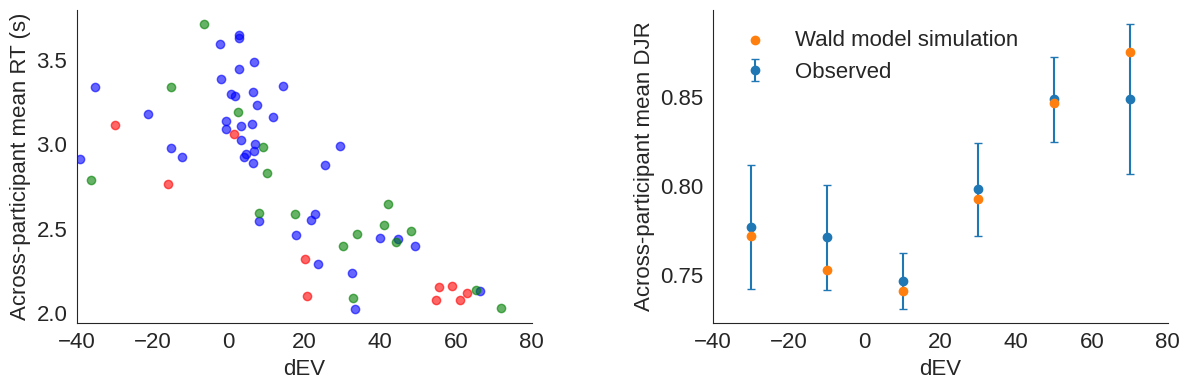

In [131]:
x = dEVs
y = mean_DJRs

# Define bin edges (you can adjust these values as needed)
bin_edges = [-40, -20, 0, 20, 40, 60, 80]  # Replace with your own vertical line positions
bin_centers = (np.array(bin_edges[:-1]) + np.array(bin_edges[1:])) / 2

bin_minus_40_minus_20 = []
bin_minus_20_minus_0 = []
bin_0_20 = []
bin_20_40 = []
bin_40_60 = []
bin_60_80 = []

for i in range(len(x)):
    if -40 < x[i] <= -20:
        bin_minus_40_minus_20.append(y[i])
    if -20 < x[i] <= 0:
        bin_minus_20_minus_0.append(y[i])
    if 0 < x[i] <= 20:
        bin_0_20.append(y[i])
    if 20 < x[i] <= 40:
        bin_20_40.append(y[i])
    if 40 < x[i] <= 60:
        bin_40_60.append(y[i])
    if 60 < x[i] <= 80:
        bin_60_80.append(y[i])
        



sim_means = [np.mean(sim_mean_djr_dev_minus_40_minus_20),
                np.mean(sim_mean_djr_dev_minus_20_0),
                np.mean(sim_mean_djr_dev_0_20),
                np.mean(sim_mean_djr_dev_20_40),
                np.mean(sim_mean_djr_dev_40_60),
                np.mean(sim_mean_djr_dev_60_80)
            ]

binned_means = [np.mean(bin_minus_40_minus_20),
                np.mean(bin_minus_20_minus_0),
                np.mean(bin_0_20),
                np.mean(bin_20_40),
                np.mean(bin_40_60),
                np.mean(bin_60_80)
               ]

binned_stds = [standard_error(bin_minus_40_minus_20),
                standard_error(bin_minus_20_minus_0),
                standard_error(bin_0_20),
                standard_error(bin_20_40),
                standard_error(bin_40_60),
                standard_error(bin_60_80)
              ]


sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fontsize = 16

# -----------------------
# Left plot: dEV vs Mean RT
# -----------------------

mask_deadline_10 = np.where(deadline_list==10)[0]
mask_deadline_8 = np.where(deadline_list==8)[0]
mask_deadline_6 = np.where(deadline_list==6)[0]

axes[0].scatter(dEVs[mask_deadline_10], mean_RTs[mask_deadline_10], color="blue", alpha=0.6)
axes[0].scatter(dEVs[mask_deadline_8], mean_RTs[mask_deadline_8], color='green', alpha=0.6)
axes[0].scatter(dEVs[mask_deadline_6], mean_RTs[mask_deadline_6], color='red', alpha=0.6)
axes[0].set_xlabel("dEV", fontsize=fontsize)
axes[0].set_ylabel("Across-participant mean RT (s)", fontsize=fontsize)
axes[0].set_xlim(-40, 80)

# -----------------------
# Right plot: dEV vs Mean DJR
# -----------------------
axes[1].set_xlabel("dEV", fontsize=fontsize)
axes[1].set_ylabel("Across-participant mean DJR", fontsize=fontsize)

# empirical with error bars
axes[1].errorbar(
    bin_centers,
    binned_means,
    yerr=binned_stds,
    fmt='o',
    capsize=3,
    label='Observed',
    zorder=1, alpha=1)


# model points
axes[1].scatter(bin_centers, sim_means, color='C1', label='Wald model simulation',  zorder=2, alpha=1)
axes[1].set_xlim(-40, 80)

# -----------------------
# Style both axes
# -----------------------
for ax in axes:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

axes[1].legend(fontsize=fontsize, frameon=False)

plt.tight_layout(w_pad=6.0)
plt.subplots_adjust(wspace=0.4)  # extra space between plots

# --- Optional save ---
#plt.savefig('../figures/dev_mean_rt_mean_djr_combined.svg', format='svg',bbox_inches='tight', transparent=True)
plt.show()

In [129]:
print(len(np.where(deadline_list==10)[0]))

42
